# Data Exploration

This notebook looks at the general statistics and features of the dataset at hand.

## Key Insights

Essays average around 294 words with consistent length across score levels, but higher-scoring essays demonstrate greater lexical diversity and more sophisticated vocabulary usage. The dataset contains 9,048 training essays across 2,386 unique prompts with no missing values, providing a robust foundation for automated essay scoring model development.

## Imports and Setup

---

We begin by importing the necessary libraries and loading the training and test datasets. The band scores are scaled and adjusted to fit the required range for further analysis.

In [1]:
import pandas as pd
import numpy as np
from os import path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

sys.path.append(path.dirname(path.abspath("")))
project_root = path.dirname(path.abspath(""))
print(project_root)

/home/finnf/dev/team-10


In [2]:
train_file_path = "../data/clean_train.csv"
test_file_path = "../data/clean_test.csv"
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [3]:
train_df["band_score"] = train_df["band_score"] * 2
test_df["band_score"] = test_df["band_score"] * 2
train_df["band_score"] = train_df["band_score"].astype(int)
test_df["band_score"] = test_df["band_score"].astype(int)

# Subtract 8 from band_score to get the range 0-10 (this is needed for cuda)
train_df["band_score"] = train_df["band_score"] - 8
test_df["band_score"] = test_df["band_score"] - 8

## Band Score Distribution

---

We visualize the distribution of band scores in both the training and test datasets to understand the spread and balance of the target variable.

<Axes: xlabel='band_score'>

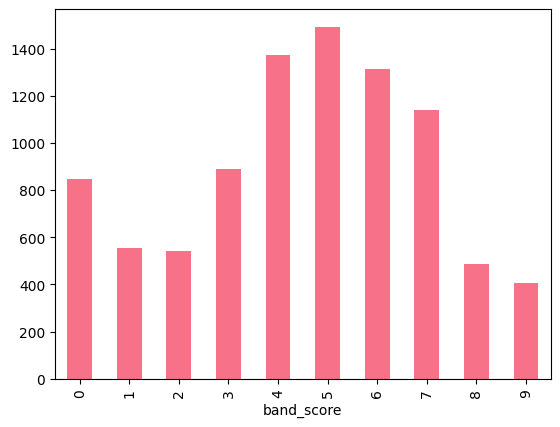

In [4]:
band_counts = train_df["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

<Axes: xlabel='band_score'>

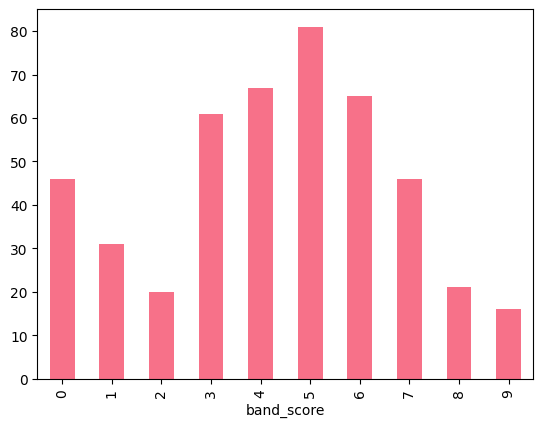

In [5]:
band_counts = test_df["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

## Basic Dataset Information

---

We display basic information about both the training and test datasets, including their shape, columns, data types, missing values, and basic statistics for the main numerical features.

In [6]:
def basic_dataset_info(df, dataset_name):
    """Display basic information about the dataset"""
    print(f"=== {dataset_name} Dataset Information ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    print(f"\nBasic Statistics:")
    print(df.describe())
    print("-" * 50)

# Display basic info for both datasets
basic_dataset_info(train_df, "Training")
basic_dataset_info(test_df, "Test")


=== Training Dataset Information ===
Shape: (9048, 14)
Columns: ['prompt', 'essay', 'evaluation', 'band_score_old', 'task_achievement_description', 'task_achievement_score', 'coherence_and_cohesion_description', 'coherence_and_cohesion_score', 'lexical_resource_description', 'lexical_resource_score', 'grammatical_range_and_accuracy_description', 'grammatical_range_and_accuracy_score', 'overall_band_score_description', 'band_score']

Data Types:
prompt                                         object
essay                                          object
evaluation                                     object
band_score_old                                 object
task_achievement_description                   object
task_achievement_score                        float64
coherence_and_cohesion_description             object
coherence_and_cohesion_score                  float64
lexical_resource_description                   object
lexical_resource_score                        float64
grammatical

## Text Feature Analysis

---

We analyze text-based features of the essays, such as word count, character count, sentence count, average words per sentence, and prompt word count. This helps us understand the general structure and length of the essays and prompts.

In [7]:
def analyze_text_features(df, dataset_name):
    """Analyze text-based features of essays"""
    print(f"=== Text Analysis for {dataset_name} Dataset ===")
    
    # Calculate text statistics
    df['essay_word_count'] = df['essay'].apply(lambda x: len(str(x).split()))
    df['essay_char_count'] = df['essay'].apply(lambda x: len(str(x)))
    df['essay_sentence_count'] = df['essay'].apply(lambda x: len(re.split(r'[.!?]+', str(x))))
    df['prompt_word_count'] = df['prompt'].apply(lambda x: len(str(x).split()))
    
    # Calculate average words per sentence
    df['avg_words_per_sentence'] = df['essay_word_count'] / df['essay_sentence_count']
    
    print(f"Essay Word Count - Mean: {df['essay_word_count'].mean():.1f}, Median: {df['essay_word_count'].median():.1f}")
    print(f"Essay Character Count - Mean: {df['essay_char_count'].mean():.1f}, Median: {df['essay_char_count'].median():.1f}")
    print(f"Essay Sentence Count - Mean: {df['essay_sentence_count'].mean():.1f}, Median: {df['essay_sentence_count'].median():.1f}")
    print(f"Average Words per Sentence - Mean: {df['avg_words_per_sentence'].mean():.1f}, Median: {df['avg_words_per_sentence'].median():.1f}")
    print(f"Prompt Word Count - Mean: {df['prompt_word_count'].mean():.1f}, Median: {df['prompt_word_count'].median():.1f}")
    print("-" * 50)
    
    return df

# Analyze text features for both datasets
train_df = analyze_text_features(train_df, "Training")
test_df = analyze_text_features(test_df, "Test")


=== Text Analysis for Training Dataset ===
Essay Word Count - Mean: 293.7, Median: 290.0
Essay Character Count - Mean: 1793.8, Median: 1775.0
Essay Sentence Count - Mean: 15.1, Median: 15.0
Average Words per Sentence - Mean: 20.1, Median: 19.5
Prompt Word Count - Mean: 31.8, Median: 32.0
--------------------------------------------------
=== Text Analysis for Test Dataset ===
Essay Word Count - Mean: 290.6, Median: 287.0
Essay Character Count - Mean: 1780.5, Median: 1758.0
Essay Sentence Count - Mean: 15.0, Median: 15.0
Average Words per Sentence - Mean: 20.2, Median: 19.4
Prompt Word Count - Mean: 31.8, Median: 32.0
--------------------------------------------------


## Text Feature Distributions

---

We plot the distributions of key text features (essay word count, character count, sentence count, and average words per sentence) to visualize their spread and identify any outliers or patterns.

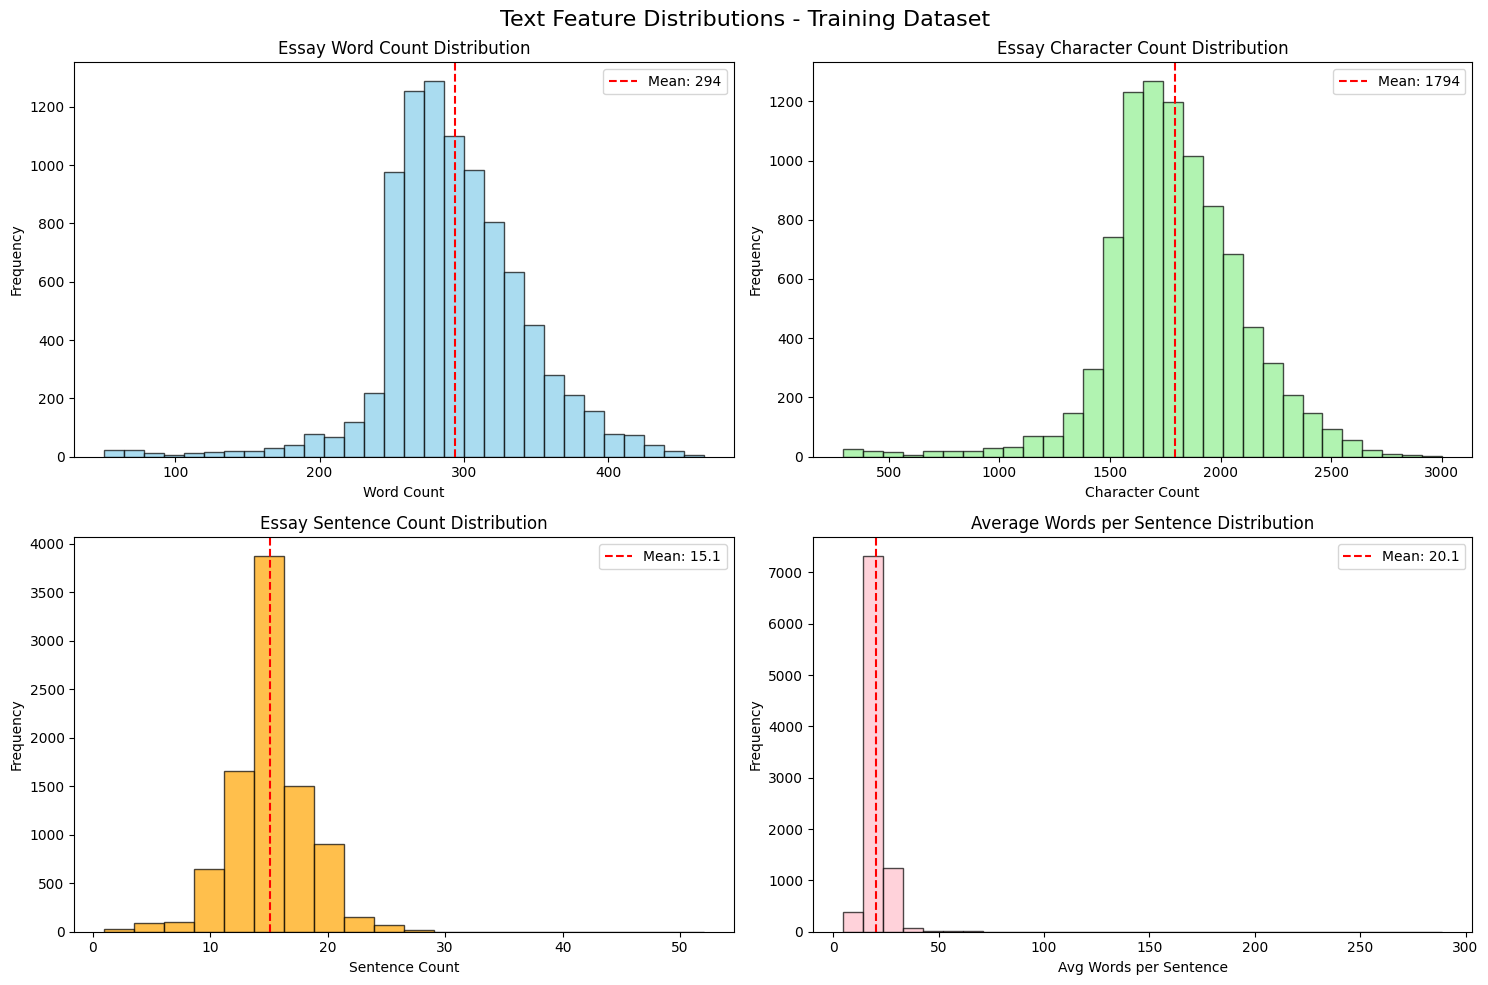

In [8]:
def plot_text_distributions(df, dataset_name):
    """Plot distributions of text features"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Text Feature Distributions - {dataset_name} Dataset', fontsize=16)
    
    # Essay word count distribution
    axes[0, 0].hist(df['essay_word_count'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Essay Word Count Distribution')
    axes[0, 0].set_xlabel('Word Count')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(df['essay_word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["essay_word_count"].mean():.0f}')
    axes[0, 0].legend()
    
    # Essay character count distribution
    axes[0, 1].hist(df['essay_char_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Essay Character Count Distribution')
    axes[0, 1].set_xlabel('Character Count')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(df['essay_char_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["essay_char_count"].mean():.0f}')
    axes[0, 1].legend()
    
    # Sentence count distribution
    axes[1, 0].hist(df['essay_sentence_count'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].set_title('Essay Sentence Count Distribution')
    axes[1, 0].set_xlabel('Sentence Count')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(df['essay_sentence_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["essay_sentence_count"].mean():.1f}')
    axes[1, 0].legend()
    
    # Average words per sentence distribution
    axes[1, 1].hist(df['avg_words_per_sentence'], bins=30, alpha=0.7, color='pink', edgecolor='black')
    axes[1, 1].set_title('Average Words per Sentence Distribution')
    axes[1, 1].set_xlabel('Avg Words per Sentence')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(df['avg_words_per_sentence'].mean(), color='red', linestyle='--', label=f'Mean: {df["avg_words_per_sentence"].mean():.1f}')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot text distributions for training data
plot_text_distributions(train_df, "Training")


## Prompt Analysis

---

We analyze the essay prompts to determine the number of unique prompts, the most common prompts, and prompt length statistics.

In [9]:
def analyze_prompts(df, dataset_name):
    """Analyze essay prompts"""
    print(f"=== Prompt Analysis for {dataset_name} Dataset ===")
    
    # Unique prompts
    unique_prompts = df['prompt'].nunique()
    print(f"Number of unique prompts: {unique_prompts}")
    
    # Most common prompts
    prompt_counts = df['prompt'].value_counts()
    print(f"\nTop 5 most common prompts:")
    for i, (prompt, count) in enumerate(prompt_counts.head().items()):
        print(f"{i+1}. ({count} essays) {prompt[:100]}...")
    
    # Prompt length analysis
    print(f"\nPrompt length statistics (words):")
    print(f"Mean: {df['prompt_word_count'].mean():.1f}")
    print(f"Median: {df['prompt_word_count'].median():.1f}")
    print(f"Min: {df['prompt_word_count'].min()}")
    print(f"Max: {df['prompt_word_count'].max()}")
    
    print("-" * 50)
    
    return prompt_counts

# Analyze prompts
train_prompt_counts = analyze_prompts(train_df, "Training")
test_prompt_counts = analyze_prompts(test_df, "Test")


=== Prompt Analysis for Training Dataset ===
Number of unique prompts: 2386

Top 5 most common prompts:
1. (332 essays) In some countries, more and more people are becoming interested in finding out about the history of ...
2. (154 essays) Some people believe that teenagers should be required to do unpaid community work in their free time...
3. (131 essays) Some people believe that studying at university or college is the best route to a successful career,...
4. (115 essays) Some people think that instead of preventing climate change, we need to find a way to live with it. ...
5. (113 essays) The best way to teach children to cooperate is through team sports at school. To what extent do you ...

Prompt length statistics (words):
Mean: 31.8
Median: 32.0
Min: 10
Max: 80
--------------------------------------------------
=== Prompt Analysis for Test Dataset ===
Number of unique prompts: 332

Top 5 most common prompts:
1. (12 essays) In some countries, more and more people are becoming int

## Correlation Analysis

---

We create a correlation matrix of all numerical features, including band score, essay word count, character count, average words per sentence, prompt word count, sentence count, unique words, and type-token ratio (TTR). The strongest correlations with band score are highlighted.

=== Correlation Analysis for Training Dataset ===


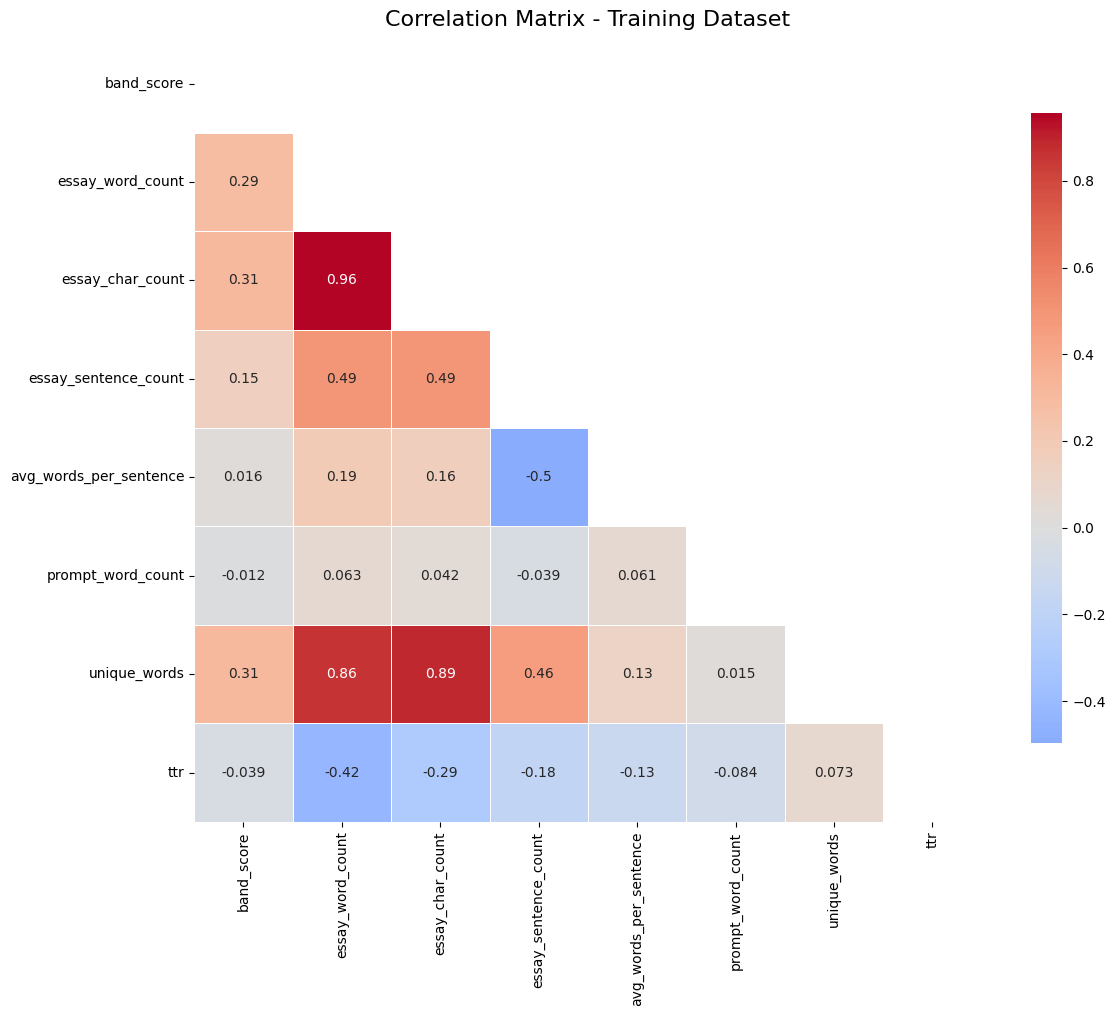

Strongest correlations with Band Score:
  unique_words             :  0.313
  essay_char_count         :  0.313
  essay_word_count         :  0.286
  essay_sentence_count     :  0.154
  ttr                      : -0.039
  avg_words_per_sentence   :  0.016
  prompt_word_count        : -0.012
--------------------------------------------------


In [11]:
def create_correlation_matrix(df, dataset_name):
    """Create a comprehensive correlation matrix of all numerical features"""
    print(f"=== Correlation Analysis for {dataset_name} Dataset ===")

    # Calculate vocabulary richness metrics
    def calculate_vocab_metrics(text):
        words = str(text).lower().split()
        unique_words = set(words)
        total_words = len(words)
        unique_words_count = len(unique_words)
        
        # Type-Token Ratio (TTR)
        ttr = unique_words_count / total_words if total_words > 0 else 0
        
        return {
            'total_words': total_words,
            'unique_words': unique_words_count,
            'ttr': ttr
        }
    
    # Apply vocabulary metrics
    vocab_metrics = df['essay'].apply(calculate_vocab_metrics)

    # Extract metrics into separate columns
    df['unique_words'] = [metrics['unique_words'] for metrics in vocab_metrics]
    df['ttr'] = [metrics['ttr'] for metrics in vocab_metrics]
    
    # Select numerical columns for correlation analysis
    numerical_cols = ['band_score', 'essay_word_count', 'essay_char_count', 'essay_sentence_count', 
                     'avg_words_per_sentence', 'prompt_word_count', 'unique_words', 'ttr']
    
    # Create correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix - {dataset_name} Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print strongest correlations with band score
    band_correlations = corr_matrix['band_score'].drop('band_score').sort_values(key=abs, ascending=False)
    print(f"Strongest correlations with Band Score:")
    for feature, corr in band_correlations.items():
        print(f"  {feature:25s}: {corr:6.3f}")
    
    print("-" * 50)
    
    return corr_matrix

# Create correlation matrix for training data
corr_matrix = create_correlation_matrix(train_df, "Training")


## Sample Essays by Band Score

---

We display sample essays for different band scores to get a qualitative sense of the data at various performance levels. For each band score, we show the prompt, essay length, unique words, TTR, and a snippet of the essay.

In [12]:
def sample_essays_by_score(df, dataset_name, n_samples=2):
    """Display sample essays for different band scores"""
    print(f"=== Sample Essays by Band Score - {dataset_name} Dataset ===")
    
    # Get unique band scores and sort them
    unique_scores = sorted(df['band_score'].unique())
    
    for score in unique_scores[:3]:  # Show samples from first 3 score levels
        print(f"\n{'='*60}")
        print(f"BAND SCORE: {score}")
        print(f"{'='*60}")
        
        score_essays = df[df['band_score'] == score]
        sample_essays = score_essays.sample(min(n_samples, len(score_essays)), random_state=42)
        
        for i, (idx, row) in enumerate(sample_essays.iterrows()):
            print(f"\nSample {i+1}:")
            print(f"Prompt: {row['prompt'][:150]}...")
            print(f"Essay Length: {row['essay_word_count']} words")
            print(f"Unique Words: {row['unique_words']}")
            print(f"TTR: {row['ttr']:.3f}")
            print(f"Essay: {str(row['essay'])[:300]}...")
            print("-" * 40)
    
    print("-" * 50)

# Sample essays by score
sample_essays_by_score(train_df, "Training")


=== Sample Essays by Band Score - Training Dataset ===

BAND SCORE: 0

Sample 1:
Prompt: Many people argue that in order to improve educational quality, high school students are encouraged to make comments or even criticism on their teache...
Essay Length: 192 words
Unique Words: 107
TTR: 0.557
Essay: Criticism may seem as both a benefit, as well as a degoratory for teachers. Some teachers may accept the advice as a means to improve their teaching standards while some may take it as a rude gesture.Some may argue that Criticism may be a rude form feedback while some may say its a positive aspect t...
----------------------------------------

Sample 2:
Prompt: News media is important in our society. Why is it so important? Do you think its influence is generally positive or negative?...
Essay Length: 332 words
Unique Words: 200
TTR: 0.602
Essay: The first problem that needs to be considered is some media actually write down untruly messages it is affected our environment and economic sta

## Most Common Words Analysis

---

We analyze the most common words in essays, comparing high-scoring essays (band score ≥ 7) and low-scoring essays (band score < 5). This helps identify vocabulary differences between strong and weak essays.

In [13]:
def analyze_most_common_words(df, dataset_name, top_n=20):
    """Analyze most common words in essays by band score"""
    print(f"=== Most Common Words Analysis for {dataset_name} Dataset ===")
    
    # Combine all essays and clean text
    def clean_text(text):
        # Remove punctuation and convert to lowercase
        text = re.sub(r'[^\w\s]', '', str(text).lower())
        # Remove common stop words
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should', 'could', 'can', 'may', 'might', 'must', 'shall', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'}
        words = [word for word in text.split() if word not in stop_words and len(word) > 2]
        return words
    
    # Get top common words for high-scoring essays (band score >= 7)
    high_score_essays = df[df['band_score'] >= 7]['essay']
    high_score_words = []
    for essay in high_score_essays:
        high_score_words.extend(clean_text(essay))
    
    high_score_common = Counter(high_score_words).most_common(top_n)
    
    # Get top common words for low-scoring essays (band score < 5)
    low_score_essays = df[df['band_score'] < 5]['essay']
    low_score_words = []
    for essay in low_score_essays:
        low_score_words.extend(clean_text(essay))
    
    low_score_common = Counter(low_score_words).most_common(top_n)
    
    print(f"High-scoring essays (band >= 7): {len(high_score_essays)} essays")
    print(f"Top {top_n} words in high-scoring essays:")
    for i, (word, count) in enumerate(high_score_common):
        print(f"  {i+1:2d}. {word:15s} ({count:4d})")
    
    print(f"\nLow-scoring essays (band < 5): {len(low_score_essays)} essays")
    print(f"Top {top_n} words in low-scoring essays:")
    for i, (word, count) in enumerate(low_score_common):
        print(f"  {i+1:2d}. {word:15s} ({count:4d})")
    
    print("-" * 50)
    
    return high_score_common, low_score_common

# Analyze common words
high_words, low_words = analyze_most_common_words(train_df, "Training")


=== Most Common Words Analysis for Training Dataset ===
High-scoring essays (band >= 7): 2032 essays
Top 20 words in high-scoring essays:
   1. people          (4656)
   2. not             (3423)
   3. more            (3203)
   4. some            (3115)
   5. which           (2672)
   6. there           (2501)
   7. from            (2316)
   8. other           (2246)
   9. many            (2001)
  10. such            (1828)
  11. example         (1681)
  12. also            (1650)
  13. about           (1626)
  14. who             (1579)
  15. one             (1542)
  16. believe         (1532)
  17. children        (1424)
  18. because         (1422)
  19. time            (1364)
  20. conclusion      (1335)

Low-scoring essays (band < 5): 4208 essays
Top 20 words in low-scoring essays:
   1. people          (11219)
   2. more            (6833)
   3. not             (6673)
   4. some            (6339)
   5. which           (5061)
   6. there           (4912)
   7. from            (4557

### [`Click here to go back to the Homepage`](../Homepage.md)